In [2]:
import numpy as np
import pickle
import pandas as pd
from datasets import DatasetEncoderDecoder, _pad_and_flip_FP
import tensorflow as tf
import matplotlib.pyplot as plt
import os

## Inspect loss

In [18]:
from extract_loss_curve_from_log import read_log_file

In [19]:
log_files = os.listdir('log/')
losses = read_log_file('log', log_files)

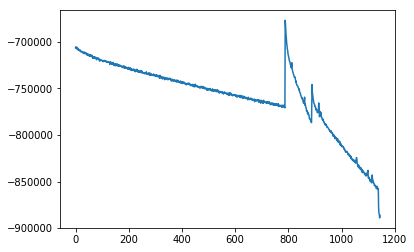

In [25]:
idx = 650
plt.plot(range(len(losses[idx:])), losses[idx:])

## debug dataset

In [57]:
from datasets import DatasetEncoderDecoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [357]:
cpu_dataset = DatasetEncoderDecoder(actual_track_datapath = '../data/New_IAHBOS2013.csv',
                                     flight_plan_datapath = '../data/cleaned_FP_tracks.CSV',
                                     flight_plan_utilize_datapath = '../data/IAH_BOS_Act_Flt_Trk_20130101_1231.CSV',
                                     shuffle_or_not = True,
                                     split = True,
                                     batch_size = 256,
                                     dep_lat = 29.98333333,
                                     dep_lon = -95.33333333)

In [358]:
for i in range(cpu_dataset.train_tracks.shape[0]):
    assert np.nonzero(cpu_dataset.train_tracks[i])[0].shape[0]//4 == cpu_dataset.train_seq_lens[i]
    assert np.nonzero(cpu_dataset.train_FP_tracks[i])[0].size//2 == cpu_dataset.train_seq_lens_FP[i]

In [377]:
cpu_dataset.next_batch()
cpu_dataset.idx

256

In [384]:
import sys

In [399]:
for _ in range(6):
    st = time.time()
    for _ in range(1000):
        a,_,b,c,d = cpu_dataset.next_batch()
    print('%.5f'%(time.time() - st))
# cpu_dataset.idx

1.02215
0.95725
1.08166
1.02556
1.00837
1.04222


In [178]:
%timeit _ = cpu_dataset.next_batch()

1.17 ms ± 18.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [179]:
cpu_dataset.idx

1280

In [140]:
# speed test
import time
fake_traj = np.random.normal(size = [2000, 240, 4])
fake_seq = np.random.randint(low = 150, high = 240, size = 2000)
fake_fp = np.random.normal(size = [2000, 50, 2])
fake_seq_fp = np.random.randint(low = 30, high = 50, size = 2000)

In [ ]:
batch_size = 256
def next_batch():
    if idx >= 2000:
        idx = 0
    for _ in range(100):
        endidx = min(idx + batch_size, 2000)
        batch_seq_lens = fake_seq[idx:endidx]
        batch_inputs = fake_traj[idx:endidx, :, :]

        batch_seq_lens_FP = fake_seq_fp[idx:endidx]
        batch_inputs_FP = fake_fp[idx:endidx, :, :]
        idx += batch_size

In [33]:
actual_track_datapath = '../data/New_IAHBOS2013.csv'
flight_plan_datapath = '../data/cleaned_FP_tracks.CSV'
flight_plan_utilize_datapath = '../data/IAH_BOS_Act_Flt_Trk_20130101_1231.CSV'
dep_lat = 29.98333333
dep_lon = -95.33333333

act_track_data = pd.read_csv(actual_track_datapath, header = 0, usecols = [0, 7, 8, 9, 12])
FP_track = pd.read_csv(flight_plan_datapath)
FP_utlize = pd.read_csv(flight_plan_utilize_datapath, header = 0, usecols = [19,1])

In [34]:
FP_track[['LATITUDE', 'LONGITUDE']] -= np.array([dep_lat, dep_lon])
avg_FP = FP_track[['LATITUDE', 'LONGITUDE']].mean().values
std_err_FP = FP_track[['LATITUDE', 'LONGITUDE']].std().values
FP_track[['LATITUDE', 'LONGITUDE']] = (FP_track[['LATITUDE', 'LONGITUDE']] - avg_FP)/std_err_FP
track_data_with_FP_id = act_track_data.merge(FP_utlize, left_on = 'FID', right_on = 'FID', how = 'inner')
# process FP tracks
FP_track_wide = FP_track.groupby('FLT_PLAN_ID').apply(lambda x: x[['LATITUDE', 'LONGITUDE']].values.reshape(1, -1)).reset_index()
FP_track_wide.columns = ['FLT_PLAN_ID', 'FP_tracks']
FP_track_wide['seq_len'] = FP_track_wide.FP_tracks.apply(lambda x: x.shape[1]//2)
track_data_with_FP = track_data_with_FP_id.merge(FP_track_wide, left_on='FLT_PLAN_ID', right_on = 'FLT_PLAN_ID')

In [35]:
track_data_with_FP['cumDT'] = track_data_with_FP.groupby('FID').DT.transform(pd.Series.cumsum)

seq_length_tracks = track_data_with_FP.groupby('FID').FLT_PLAN_ID.count().values.astype(np.int32)
tracks = track_data_with_FP[['Lat', 'Lon', 'Alt', 'cumDT']].values.astype(np.float32)

# use delta lat and delta lon
tracks = tracks - np.array([dep_lat, dep_lon, 0, 0])
avg = tracks.mean(axis = 0)
std_err = tracks.std(axis = 0)
tracks = (tracks - avg)/std_err
tracks_split = np.split(tracks, np.cumsum(seq_length_tracks))[:-1]

FP_track_order = track_data_with_FP.groupby('FID')[['FP_tracks', 'seq_len']].head(1)
seq_length_FP = FP_track_order.seq_len.values.astype(np.int32)
FP_tracks_split = FP_track_order.FP_tracks.values
FP_tracks_split1 = _pad_and_flip_FP(FP_tracks_split, seq_length_FP)

In [56]:
FP_tracks_split1.shape

(1678, 49, 2)

In [55]:
for i in range(len(tracks_split)):
    assert tracks_split[i].shape[0] == seq_length_tracks[i]
    assert FP_tracks_split[i].shape[1]//2 == seq_length_FP[i]

In [158]:
print(FP_tracks_split1.shape)
print(tracks.shape)

(1678, 49, 2)
(312456, 4)


In [259]:
a = np.arange(10)


array([3, 8, 9, 7, 2, 0, 5, 1, 4, 6])

In [262]:
shuffle(a)

array([9, 6, 7, 2, 5, 1, 4, 0, 3, 8])

## debug neural network

In [3]:
%load_ext autoreload
%autoreload 2
from rnn_encoder_decoder import LSTM_model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
def launchGraph():
    targetLength = 4
    n_encode = 2
    n_input = 4
    conf_path = 'configs/encoder_decoder_nn.ini'
    sample_traj = False
    input_encode_tensor = tf.placeholder(dtype = tf.float32, shape = [None, None, n_encode], name = 'encode_tensor')
    seq_len_encode = tf.placeholder(dtype = tf.int32, shape = [None], name = 'seq_length_encode')
    input_tensor = tf.placeholder(dtype = tf.float32, shape = [None, None, n_input], name = 'decode_feature_map')
    target = tf.placeholder(dtype = tf.float32, shape = [None, None, targetLength], name = 'target')
    seq_length = tf.placeholder(dtype = tf.int32, shape = [None], name = 'seq_length_decode')

    MODEL = LSTM_model(conf_path, 
                        input_encode_tensor, 
                        seq_len_encode, 
                        n_encode, 
                        input_tensor, 
                        seq_length, 
                        n_input, 
                        target, 
                        not sample_traj)
    return MODEL

In [221]:
graph = tf.Graph()
with graph.as_default():
    Model = launchGraph()
    with tf.Session() as sess:
        sess.graph.finalize()
        print(sess.graph.finalized)
#         writer = tf.summary.FileWriter('debug_file/graph', graph=sess.graph)
#         writer.flush()

True


In [16]:
Model.optimizer

<tf.Operation 'training_optimizer/Momentum' type=NoOp>

In [404]:
a = np.arange(1000)
%timeit shuffle(a)

48.7 µs ± 3.29 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [405]:
a = np.arange(1000)
%timeit np.random.permutation(a)

26.5 µs ± 3.06 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [406]:
a = np.arange(1000)
%timeit np.random.shuffle(a)

23.7 µs ± 2.52 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## Synthetic Data Test

In [1]:
from scipy.interpolate import interp1d

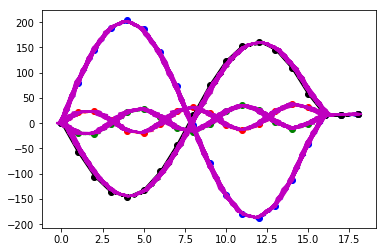

In [30]:
# create synthetic data
x = np.arange(0, 19, 1)
y = np.arange(0, 19, 1, dtype = np.float32)
x_tmp = x[:16]
y1 = y.copy()
y2 = y.copy()
y3 = y.copy()
y4 = y.copy()

y1[:16] = x_tmp + 25*np.sin(1*x_tmp)
y2[:16] = x_tmp - 25*np.sin(1*x_tmp)
y3[:16] = x_tmp + 200*np.sin(0.4*x_tmp)
y4[:16] = x_tmp - 150*np.sin(0.4*x_tmp)

f1 = interp1d(x, y1)
f2 = interp1d(x, y2)
f3 = interp1d(x, y3)
f4 = interp1d(x, y4)

xnew = np.arange(0, 18, 0.35)
y1_new = f1(xnew)
y2_new = f2(xnew)
y3_new = f3(xnew)
y4_new = f4(xnew)

N1, N2, N3, N4 = 200, 300, 500, 800
ynoise1 = np.random.normal(loc = 0, scale = 0.2, size = (N1, xnew.size))
ynoise2 = np.random.normal(loc = 0.5, scale = 0.5, size = (N2, xnew.size))
ynoise3 = np.random.uniform(low = -1, high = .5, size = (N3, xnew.size))
ynoise4 = np.random.uniform(low = -.2, high = .4, size = (N4, xnew.size))

xnoise1 = np.random.normal(loc = 0, scale = 0.1, size = (N1, xnew.size))
xnoise2 = np.random.normal(loc = 0, scale = 0.1, size = (N2, xnew.size))
xnoise3 = np.random.normal(loc = -.05, scale = .05, size = (N3, xnew.size))
xnoise4 = np.random.normal(loc = .2, scale = .05, size = (N4, xnew.size))

syn_traj1y = ynoise1 + y1_new
syn_traj2y = ynoise2 + y2_new
syn_traj3y = ynoise3 + y3_new
syn_traj4y = ynoise4 + y4_new

syn_traj1x = xnoise1 + xnew
syn_traj2x = xnoise2 + xnew
syn_traj3x = xnoise3 + xnew
syn_traj4x = xnoise4 + xnew

syn_traj1 = np.dstack((syn_traj1x,syn_traj1y))
syn_traj2 = np.dstack((syn_traj2x,syn_traj2y))
syn_traj3 = np.dstack((syn_traj3x,syn_traj3y))
syn_traj4 = np.dstack((syn_traj4x,syn_traj4y))
syn_traj = np.concatenate((syn_traj1,syn_traj2,syn_traj3,syn_traj4), axis = 0)

plt.plot(x, y1, 'ro-', zorder = 2)
plt.plot(x, y2, 'go-', zorder = 2)
plt.plot(x, y3, 'bo-', zorder = 2)
plt.plot(x, y4, 'ko-', zorder = 2)

_ = plt.plot(syn_traj1x, syn_traj1y, 'ro', ms = 0.1, zorder = 1)
_ = plt.plot(syn_traj2x, syn_traj2y, 'go', ms = 0.1, zorder = 1)
_ = plt.plot(syn_traj3x, syn_traj3y, 'bo', ms = 0.1, zorder = 1)
_ = plt.plot(syn_traj4x, syn_traj4y, 'ko', ms = 0.1, zorder = 1)
for traj in syn_traj:
    _ = plt.plot(traj[:, 0], traj[:, 1], 'm-')

In [68]:
FID = np.repeat(range(N1+N2+N3+N4), syn_traj.shape[1])
lat = syn_traj[:,:,0].reshape(-1,1)
lon = syn_traj[:,:,1].reshape(-1,1)
alt = 0
time = (syn_traj[:,:,0]*20).astype(np.int16)//2
time = time * (time>=0)
dtime = np.diff(time, axis = 1)
dtime = np.insert(dtime, 0, 0, axis = 1).reshape(-1,1)

In [69]:
syn_track = pd.read_csv('test_on_synthetic_data/syn_track.csv', header = 0, nrows = 0)
syn_fp = pd.read_csv('test_on_synthetic_data/syn_fp.CSV', header = 0, nrows = 0)
syn_fp_util = pd.read_csv('test_on_synthetic_data/syn_fp_util.csv', header = 0, nrows = 0)

In [70]:
syn_track['FID'] = FID
syn_track['Lat'] = lat
syn_track['Lon'] = lon
syn_track['DT'] = dtime
syn_track['Alt'] = np.random.uniform(0, 300, size=FID.size)
syn_track = syn_track.fillna(0)

In [71]:
fp_id = np.repeat(range(4), x.shape)
syn_fp_unique = np.concatenate((np.vstack((x,y1)).T, np.vstack((x,y2)).T, np.vstack((x,y3)).T, np.vstack((x,y4)).T), axis = 0)

In [72]:
syn_fp['FLT_PLAN_ID'] = fp_id
syn_fp['LATITUDE'] = syn_fp_unique[:, 0]
syn_fp['LONGITUDE'] = syn_fp_unique[:, 1]

In [73]:
fp_util = np.repeat(np.arange(4), [N1,N2,N3,N4])
syn_fp_util['FID'] = np.arange(N1+N2+N3+N4)
syn_fp_util['FLT_PLAN_ID'] = fp_util
syn_fp_util = syn_fp_util.fillna(0)

In [74]:
syn_fp.head(2)

,FLT_PLAN_ID,LATITUDE,LONGITUDE
0,0,0.0,0.000000
1,0,1.0,22.036774


In [75]:
syn_fp_util[['FID', 'FLT_PLAN_ID']].head(2)

,FID,FLT_PLAN_ID
0,0,0
1,1,0


In [76]:
syn_track.head(2)

,FID,FlightIdx,ACID,ACT_DATE,DEP,ARR,Elap_Time,Lat,Lon,Alt,GroundSpeed,ID2,DT,Dist,Speed,CumDist
0,0,0,0,0,0,0,0,0.026750,-0.156080,260.461264,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0.268029,7.972106,247.762016,0,0,2,0,0,0


In [77]:
syn_track.to_csv('test_on_synthetic_data/syn_track.csv', index=False)
syn_fp.to_csv('test_on_synthetic_data/syn_fp.CSV', index = False)
syn_fp_util.to_csv('test_on_synthetic_data/syn_fp_util.csv', index = False)

In [201]:
from datasets import DatasetEncoderDecoder
cpu_dataset = DatasetEncoderDecoder(actual_track_datapath = 'test_on_synthetic_data/syn_track.csv',
                                 flight_plan_datapath = 'test_on_synthetic_data/syn_fp.CSV',
                                 flight_plan_utilize_datapath = 'test_on_synthetic_data/syn_fp_util.csv',
                                 shuffle_or_not = True,
                                 split = True,
                                 batch_size = 256,
                                 dep_lat = 0,
                                 dep_lon = 0)

In [184]:
## visual sampling
import pickle
initial_track = pd.read_csv('test_on_synthetic_data/test/test_track.csv')
initial_fp = pd.read_csv('test_on_synthetic_data/test/test_fp.csv')
pred, pred_cov, buffer_logprob = pickle.load(open('test_on_synthetic_data/test/samp_mu_cov_test_delta_s1_w100.pkl', 'rb'))

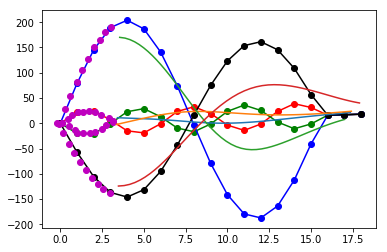

In [185]:
plt.plot(initial_track.Lat.values, initial_track.Lon.values, 'mo', zorder = 10)
plt.plot(x, y1, 'ro-', zorder = 2)
plt.plot(x, y2, 'go-', zorder = 2)
plt.plot(x, y3, 'bo-', zorder = 2)
plt.plot(x, y4, 'ko-', zorder = 2)

# idx = range(100)
# idx = range(25)
# for idx in range(3, 20, 5):
for idx in range(4):
    _ = plt.plot(pred[idx, :, 0], pred[idx, :, 1], '-', ms = 1, zorder = 20)

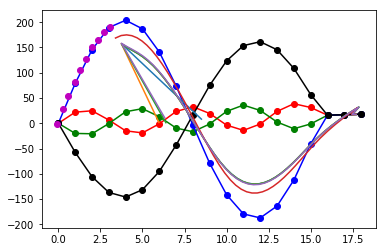

In [116]:
plt.plot(initial_track.Lat.values, initial_track.Lon.values, 'mo', zorder = 10)
plt.plot(x, y1, 'ro-', zorder = 2)
plt.plot(x, y2, 'go-', zorder = 2)
plt.plot(x, y3, 'bo-', zorder = 2)
plt.plot(x, y4, 'ko-', zorder = 2)

# idx = range(100)
idx = range(25)
for idx in range(5):
    _ = plt.plot(pred[idx, :, 0], pred[idx, :, 1], '-', ms = 1, zorder = 20)

In [152]:
cpu_dataset.all_seq_lens_FP

array([19, 19, 19, ..., 19, 19, 19])

In [153]:
cpu_dataset.all_FP_tracks

array([[[ 1.22190383e+14,  1.70860000e-01],
        [ 1.08613674e+14,  1.52220058e-01],
        [ 9.50369646e+13,  1.33580115e-01],
        ...,
        [-9.50369646e+13,  2.54691627e+00],
        [-1.08613674e+14,  1.30572806e+00],
        [-1.22190383e+14, -1.64658968e-01]],

       [[ 1.22190383e+14,  1.70860000e-01],
        [ 1.08613674e+14,  1.52220058e-01],
        [ 9.50369646e+13,  1.33580115e-01],
        ...,
        [-9.50369646e+13,  2.54691627e+00],
        [-1.08613674e+14,  1.30572806e+00],
        [-1.22190383e+14, -1.64658968e-01]],

       [[ 1.22190383e+14,  1.70860000e-01],
        [ 1.08613674e+14,  1.52220058e-01],
        [ 9.50369646e+13,  1.33580115e-01],
        ...,
        [-9.50369646e+13, -2.13310060e+00],
        [-1.08613674e+14, -1.23482934e+00],
        [-1.22190383e+14, -1.64658968e-01]],

       ...,

       [[ 1.22190383e+14,  1.70860000e-01],
        [ 1.08613674e+14,  1.52220058e-01],
        [ 9.50369646e+13,  1.33580115e-01],
        ...,
     

## debug sample

In [61]:
from scipy.stats import multivariate_normal as mvn
from datasets import DatasetEncoderDecoder, _pad_and_flip_FP

In [184]:
cpu_dataset = DatasetEncoderDecoder(actual_track_datapath = '../data/New_IAHBOS2013.csv',
                                     flight_plan_datapath = '../data/cleaned_FP_tracks.CSV',
                                     flight_plan_utilize_datapath = '../data/IAH_BOS_Act_Flt_Trk_20130101_1231.CSV',
                                     shuffle_or_not = True,
                                     split = True,
                                     batch_size = 128)

In [63]:
dep_lat = 29.98333333
dep_lon = -95.33333333

track_data = pd.read_csv('../data/test/test_data_more_points.csv', header = 0)
tracks = track_data[['Lat', 'Lon', 'Alt', 'cumDT']].values.astype(np.float32)
seq_length = track_data.groupby('SEQ').Lat.count().values.astype(np.int32)
tracks_split = np.split(tracks, np.cumsum(seq_length))[:-1]
tracks_split = np.array(tracks_split)

flight_plan = pd.read_csv('../data/test/test_flight_plan_more_points.csv', header = 0)
fp_tracks = flight_plan[['Lat', 'Lon']].values.astype(np.float32)
fp_tracks = flight_plan[['Lat', 'Lon']].values.astype(np.float32)
fp_tracks = (fp_tracks - np.array([cpu_dataset.dep_lat, cpu_dataset.dep_lon]) - cpu_dataset.FP_mean)/cpu_dataset.FP_std
fp_seq_length = flight_plan.groupby('SEQ').Lat.count().values.astype(np.int32)

fp_tracks_split = _pad_and_flip_FP(np.array(np.split(fp_tracks, np.cumsum(fp_seq_length))[:-1]), fp_seq_length)

# subtract depature's lat lon
tracks_split -= np.array([dep_lat, dep_lon, 0, 0])
# fp_tracks_split -= np.array([dep_lat, dep_lon])

In [20]:
# predicted_tracks = np.repeat(start_tracks, width, axis = 0)
start_tracks = (tracks_split - cpu_dataset.data_mean)/cpu_dataset.data_std
flight_plan = fp_tracks_split
flight_plan_length = fp_seq_length

In [16]:
decode_final_state, encoder_state = pickle.load(open('debug_file/encoder_state_debug.pkl', 'rb'))

###### ok

In [21]:
n_seq, n_time, _ = start_tracks.shape
width = 10
keep = 10
buffer_size = width * keep
print('buffer_size = %d'%buffer_size)
print('n_seq*buffer_size = %d'%(n_seq*buffer_size))

buffer_size = 100
n_seq*buffer_size = 300


In [22]:
buffer_track = np.repeat(start_tracks, buffer_size, axis = 0)
buffer_fp = np.repeat(flight_plan, buffer_size, axis = 0)
buffer_fp_len = np.repeat(flight_plan_length, buffer_size)
buffer_total_logprob = np.zeros(shape = (buffer_size * n_seq, 1), dtype = np.float32)

last_input_track_point = buffer_track[:, -1, None]

In [69]:
state, pi_logprob, coords_sample, pi_sample, coords_logprob, coords_mu, coords_cov = pickle.load(open('debug_file/inner_loop_debug.pkl', 'rb'))
prev_state = pickle.load(open('debug_file/init_state_debug.pkl', 'rb'))

In [51]:
a = (coords_mu * cpu_dataset.data_std + cpu_dataset.data_mean) + np.array([cpu_dataset.dep_lat, cpu_dataset.dep_lon, 0, 0])

In [64]:
print(pi_logprob.shape)
print(coords_logprob.shape)
print(coords_mu.shape)
print(coords_cov.shape)

(300, 10)
(300, 10)
(300, 10, 4)
(300, 10, 4, 4)


In [26]:
pi_logprob_sample = pi_logprob[range(buffer_size*n_seq), pi_sample.flatten(), None]
coords_logprob_sample = coords_logprob[range(buffer_size*n_seq), pi_sample.flatten(), None]
total_log_prob = np.sum(pi_logprob, axis = 1, keepdims=True) + np.sum(coords_logprob, axis = 1, keepdims=True)
buffer_total_logprob += (pi_logprob_sample + coords_logprob_sample)/total_log_prob
tmp_buffer_total_logprob = buffer_total_logprob.reshape(n_seq, buffer_size, 1)
top_k_idx = np.argsort(tmp_buffer_total_logprob, axis = 1)[:, (-width):,:] + (np.repeat(range(n_seq), width)*buffer_size).reshape(n_seq, width, 1)
top_k_idx = top_k_idx.reshape(-1)
top_k_logprob = buffer_total_logprob[top_k_idx]
# selected_coords = coords_sample[top_k_idx, pi_sample[top_k_idx].flatten(), None] # shape of [width*n_seq, 1, 4]
# last_input_track_point = np.repeat(selected_coords, keep, axis = 0)
# buffer_total_logprob = np.repeat(top_k_logprob, keep, axis = 0)

In [27]:
state = tuple([tf.nn.rnn_cell.LSTMStateTuple(c = np.repeat(tmp_state.c[top_k_idx], keep, axis = 0), 
                                                        h = np.repeat(tmp_state.h[top_k_idx], keep, axis = 0)) for tmp_state in state])

In [28]:
state, pi_logprob, coords_sample, pi_sample, coords_logprob, final_tracks, top_k_idx_seq, buffer_total_logprob, all_mus, all_covs = pickle.load(open('debug_file/outer_loop_debug.pkl', 'rb'))

In [29]:
def arrange_top_k(top_k_idx_seq, keep_search):
    final_seq = []
    i = 0
    for seq in top_k_idx_seq[::-1]:
        if i == 0:
            final_seq.append(seq)
            idx = seq//keep_search
        else:
            seq = seq[idx]
            final_seq.append(seq)
            idx = seq // keep_search
        i += 1
    final_seq = np.array(final_seq)
    return final_seq

## Debug sample_seq_mu_cov

In [19]:
predicted_tracks, predicted_tracks_cov, buffer_total_logprob = pickle.load(open('../data/test/samp_mu_cov_test_delta_s3_w10.pkl', 'rb'))

## Inspect sampled traj

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
%matplotlib inline

In [10]:
def plot_fp_act(FP_ID, 
                IAH_BOS_FP_utilize, 
                IAH_BOS_ACT_track, 
                IAH_BOS_FP_track, 
                feed_track = None, 
                pred_track = None, 
                pred_track_mu = None,
                k = 9, 
                sort = True):
    ori_lat = 29.98333333; ori_lon = -95.33333333
    des_lat = 42.36666667; des_lon = -71
    
    fig = plt.figure(figsize=(8,6))
    m = Basemap(llcrnrlon = -100,llcrnrlat = 27,urcrnrlon = -68,urcrnrlat = 46,projection='merc')
    m.drawmapboundary(fill_color='#8aeaff')
    m.fillcontinents(color='#c5c5c5', lake_color='#8aeaff')
#     m.bluemarble()
    m.drawcoastlines(linewidth=0.5)
    m.drawcountries(linewidth=0.5)
    m.drawstates(linewidth=0.5)
    m.drawparallels(np.arange(10.,35.,5.))
    m.drawmeridians(np.arange(-120.,-80.,10.))
    
    x1, y1 = m(ori_lon, ori_lat)
    x2, y2 = m(des_lon, des_lat)
    plt.plot(x1,y1, 'r*', ms = 15, zorder = 999)
    plt.plot(x2,y2, 'r*', ms = 15, zorder = 999)

    fid_fp1 = IAH_BOS_FP_utilize.loc[IAH_BOS_FP_utilize.FLT_PLAN_ID == FP_ID, 'FID'].values
    print('%d flights filed flight plan %s'%(fid_fp1.shape[0], FP_ID))
    plot_track = IAH_BOS_ACT_track.loc[IAH_BOS_ACT_track.FID.isin(fid_fp1)]
    plot_fp = IAH_BOS_FP_track.loc[IAH_BOS_FP_track.FLT_PLAN_ID == FP_ID]
    x_fp, y_fp = m(plot_fp.LONGITUDE.values, plot_fp.LATITUDE.values)
    
    feed_x, feed_y = m(feed_track.Lon.values, feed_track.Lat.values)
    feed, = plt.plot(feed_x, feed_y, 'o-', ms = 4, linewidth = 3, color='g', label = 'feed tracks', zorder = 99999)
    
    for gpidx, gp in plot_track.groupby('FID'):
        x,y = m(gp.Lon.values, gp.Lat.values)
        actual, = plt.plot(x,y,'-', linewidth = 1, color='y', label = 'Actual Tracks')
    fp, = plt.plot(x_fp, y_fp, '-', linewidth = 2, color='r', label = 'Flight Plans', zorder = 9999)
    
    if pred_track is not None:
        if sort:
            x, y = m(pred_track[k][pred_track[k][:,3].argsort()][:, 1], pred_track[k][pred_track[k][:,3].argsort()][:, 0])
        else:
            x, y = m(pred_track[k, :, 1], pred_track[k, :, 0])
        pred_fig, = plt.plot(x,y, 'o--', ms = 3)
    if pred_track_mu is not None:
        x, y = m(pred_track_mu[k][:, 1], pred_track_mu[k][:, 0])
        plt.plot(x,y, 'mo--', ms = 2)

#     plt.legend()
    plt.show()
    return plot_track, plot_fp

In [4]:
actual_track_datapath = '../data/New_IAHBOS2013.csv'
flight_plan_datapath = '../data/cleaned_FP_tracks.CSV'
flight_plan_utilize_datapath = '../data/IAH_BOS_Act_Flt_Trk_20130101_1231.CSV'

act_track_data = pd.read_csv(actual_track_datapath, header = 0, usecols = [0, 7, 8, 9, 12])
FP_track = pd.read_csv(flight_plan_datapath)
FP_utlize = pd.read_csv(flight_plan_utilize_datapath, header = 0, usecols = [19,1])

In [5]:
feed_data = pd.read_csv('../data/test/test_data_more_points.csv', header = 0)
pred, predicted_tracks_cov, buffer_total_logprob, buffer_pi_prob = pickle.load(open('../data/test/samp_mu_cov_test_delta_s2_w10.pkl', 'rb'))
# pred, final_top_k_idx_seq, buffer_total_logprob = pickle.load(open('../data/test/test_delta_w30_k300.pkl', 'rb'))

d:\program\anaconda\envs\tensorflow\lib\site-packages\mpl_toolkits\basemap\__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
d:\program\anaconda\envs\tensorflow\lib\site-packages\mpl_toolkits\basemap\__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


215 flights filed flight plan FP_00003


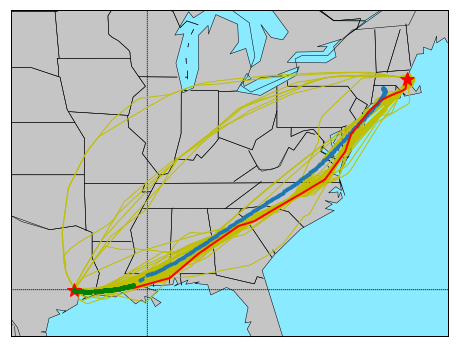

In [11]:
plot_track, plot_fp = plot_fp_act('FP_00003', FP_utlize, act_track_data, FP_track, 
                                  feed_track = feed_data.loc[feed_data.SEQ==1], 
                                  pred_track=pred, 
                                  pred_track_mu = None,
                                  k = 11, 
                                  sort = False)

In [330]:
np.argmax(buffer_pi_prob[100:200, 6])

30

215 flights filed flight plan FP_00003


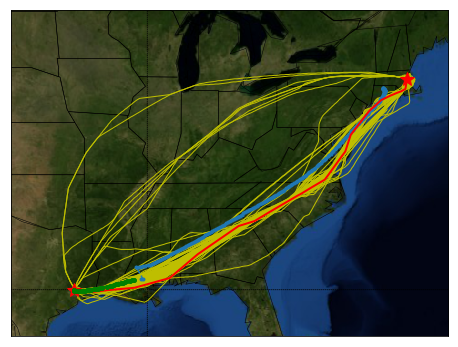

In [345]:
plot_track, plot_fp = plot_fp_act('FP_00003', FP_utlize, act_track_data, FP_track, 
                                  feed_track = feed_data.loc[feed_data.SEQ==2], 
                                  pred_track=pred, 
                                  pred_track_mu = None,
                                  k = 111, 
                                  sort = False)

457 flights filed flight plan FP_00002


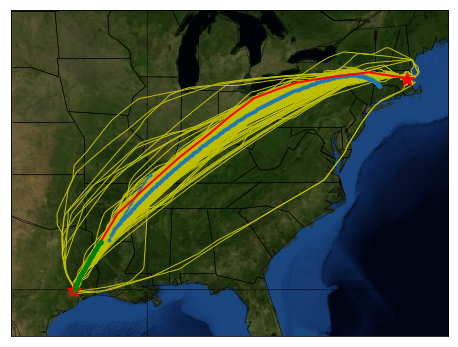

In [356]:
plot_track, plot_fp = plot_fp_act('FP_00002', FP_utlize, act_track_data, FP_track, 
                                  feed_track = feed_data.loc[feed_data.SEQ==3], 
                                  pred_track=pred, 
                                  pred_track_mu = None,
                                  k = 243, 
                                  sort = False)

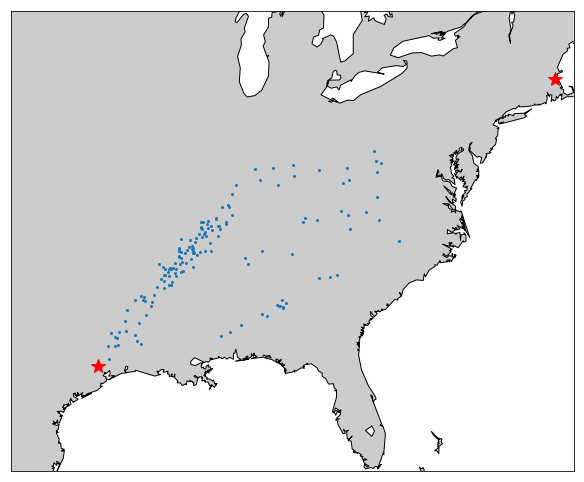

In [76]:
fig=plt.figure(figsize=(12,8))
ax=fig.add_axes([0.1,0.1,0.8,0.8])
# setup mercator map projection.
m = Basemap(llcrnrlon=-100.,llcrnrlat=25.,urcrnrlon=-70.,urcrnrlat=45.,\
            rsphere=(6378137.00,6356752.3142),\
            resolution='l',projection='merc',\
            lat_0=40.,lon_0=-90.,lat_ts=20.)
# # nylat, nylon are lat/lon of New York
ori_lat = 29.98333333; ori_lon = -95.33333333
# # lonlat, lonlon are lat/lon of London.
des_lat = 42.36666667; des_lon = -71

x1, y1 = m(ori_lon, ori_lat)
x2, y2 = m(des_lon, des_lat)
m.drawcoastlines()
m.fillcontinents()
for k in range(1):
    # k = 2
    x, y = m(pred[k][:, 1], pred[k][:, 0])
    plt.plot(x,y, 'o', ms = 2)
plt.plot(x1,y1, 'r*', ms = 15)
plt.plot(x2,y2, 'r*', ms = 15)
plt.show()